## Power for pcqtls
are pcqtls (especially pc1qtls) boosting power to detect signals that exist in signle egene analysis, but just are below detection thresholds?

Looking at the set of pcqtls that don't overlap with eqtls, then ask if the nominal p value distribution for the eqtls is enriched for low p values

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks

### load in data
nominal p values and overlap dfs

In [3]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_allgenes.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
eqtl_output_dir = config['eqtl_output_dir']
pcqtl_output_dir = config['pcqtl_output_dir']
overlap_output_dir = config['overlap_output_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type


In [20]:
# load nominal p value dfs

def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    #e_nominal_df['variant_pos'] = var_pos(e_nominal_df)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    #e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [21]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    #pc_nominal_df['variant_pos'] = var_pos(pc_nominal_df)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    #pc_nominal_df['cluster_size'] = pc_nominal_df['phenotype_id'].str.split('_').str.len() - 1
    return pc_nominal_df

pc1_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc1_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_1.cis_qtl_pairs.chr{chr_id}.parquet'))
pc1_nominal_df = pd.concat(pc1_nominal_dfs)


  0%|          | 0/22 [00:00<?, ?it/s]

In [22]:
pc2_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc2_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pc_2.cis_qtl_pairs.chr{chr_id}.parquet'))
pc2_nominal_df = pd.concat(pc2_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [6]:
# write out? This was taking forever, so skiiping for now. It's ~ 6 minutes to load in data 

#e_nominal_df.to_csv(f'{e_out_prefix}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')
#pc1_nominal_df.to_csv(f'{pc_out_prefix}/{tissue_id}.v8.pc_1.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')
#pc2_nominal_df.to_csv(f'{pc_out_prefix}/{tissue_id}.v8.pc_2.cis_qtl_pairs.csv.gz', sep='\t', compression='gzip')

In [30]:
# load in the overlap df so we can pull credible sets that are pcqtls not eqtls
overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']
pc1_nominal_df['var_cluster'] = pc1_nominal_df['variant_id'] + '_' + pc1_nominal_df['cluster_id']
pc2_nominal_df['var_cluster'] = pc2_nominal_df['variant_id'] + '_' + pc2_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']


## nominal p value distribution

In [31]:
def plot_nominal_ps(exclusive_df, min_e_per_cluster=False):
    fig, ax = plt.subplots(figsize=(8, 6))

    # lead variants exclusive to pc1
    pc1_nominal_ps = pc1_nominal_df[pc1_nominal_df['var_cluster'].isin(exclusive_df['var_cluster'])]
    pc2_nominal_ps = pc2_nominal_df[pc2_nominal_df['var_cluster'].isin(exclusive_df['var_cluster'])]
    e_nominal_ps = e_nominal_df[e_nominal_df['var_cluster'].isin(exclusive_df['var_cluster'])]
    if min_e_per_cluster:
        e_nominal_ps = e_nominal_ps.loc[e_nominal_ps.groupby('cluster_id')['pval_nominal'].idxmin()]

    # make the cumiulative plots
    sns.histplot(e_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), stat='density', element='step', fill=False,cumulative=True, label='e', ax=ax)
    sns.histplot(pc1_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), stat='density', element='step', fill=False,cumulative=True, label='pc1', ax=ax)
    sns.histplot(pc2_nominal_ps['pval_nominal'], bins=np.arange(0,1,.001), stat='density', element='step', fill=False,cumulative=True, label='pc2', ax=ax)

    sns.histplot(np.arange(0,1,.001), bins=np.arange(0,1,.001), stat='density', element='step', fill=False,cumulative=True, label='null', ax=ax)

    ax.set_ylabel('Cumulative density')
    ax.set_xlabel('Nominal p value')
    ax.legend()
    return ax


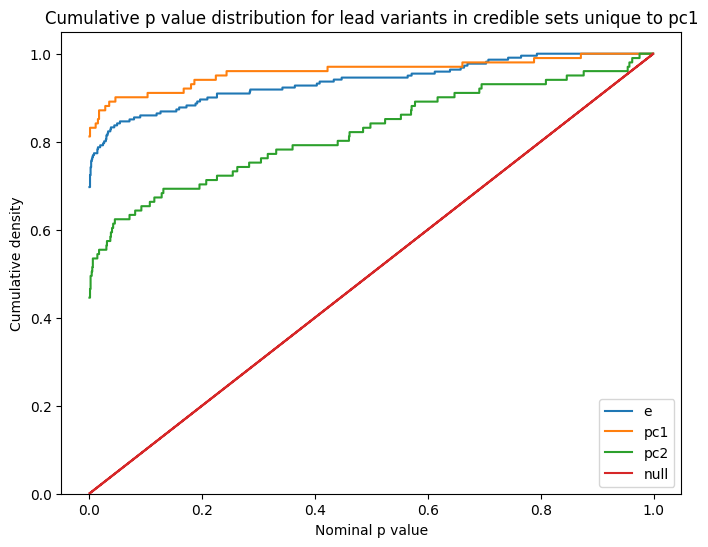

In [32]:

ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc1_overlap']>0)])
ax.set_title('Cumulative p value distribution for lead variants in credible sets unique to pc1')
plt.show()


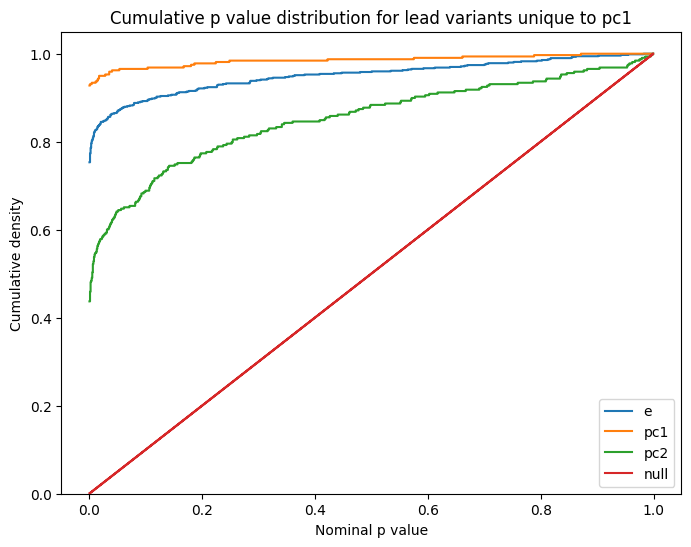

In [33]:
# lead variants exclusive to pc2
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_samelead']==0)&(overlap_df['num_pc1_samelead']>0)])
ax.set_title('Cumulative p value distribution for lead variants unique to pc1')
plt.show()

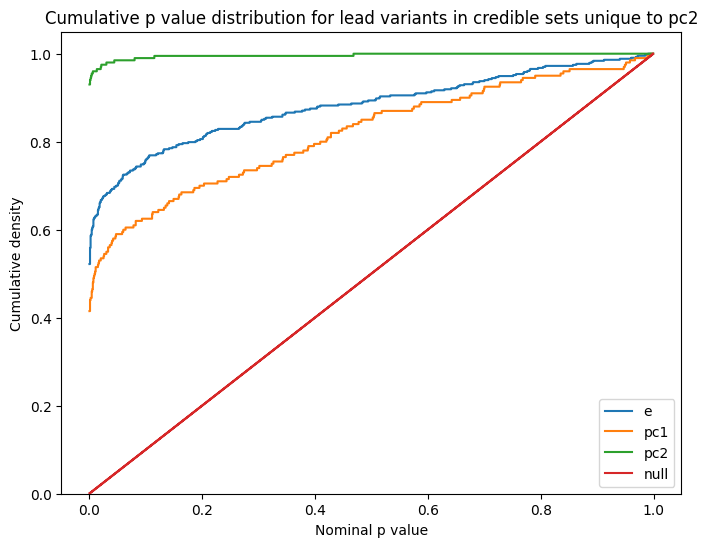

In [35]:
# lead variants exclusive to pc2
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']==0)&(overlap_df['num_pc2_overlap']>0)])
ax.set_title('Cumulative p value distribution for lead variants in credible sets unique to pc2')
plt.show()

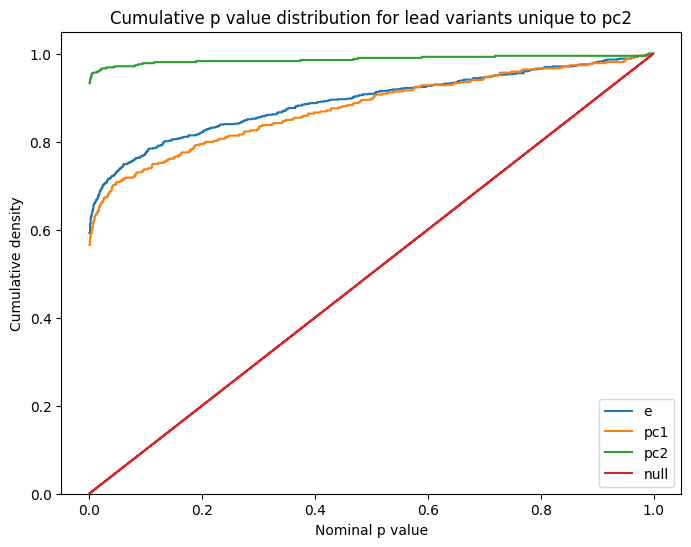

In [36]:
# lead variants exclusive to pc2
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_samelead']==0)&(overlap_df['num_pc2_samelead']>0)])
ax.set_title('Cumulative p value distribution for lead variants unique to pc2')
plt.show()

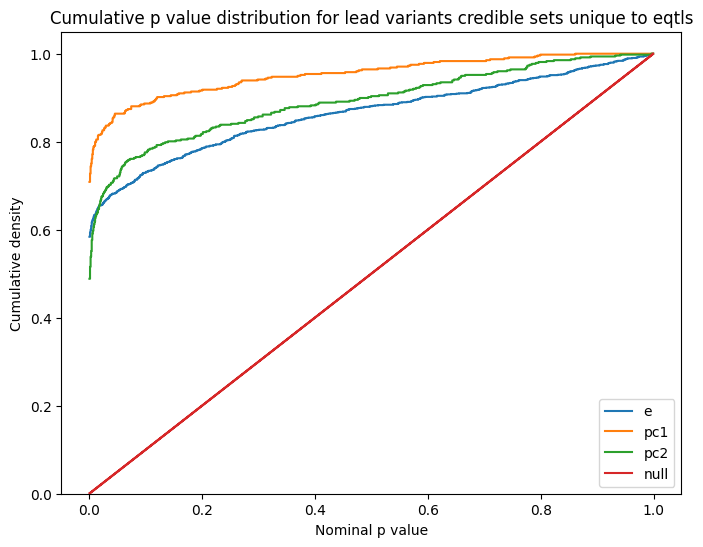

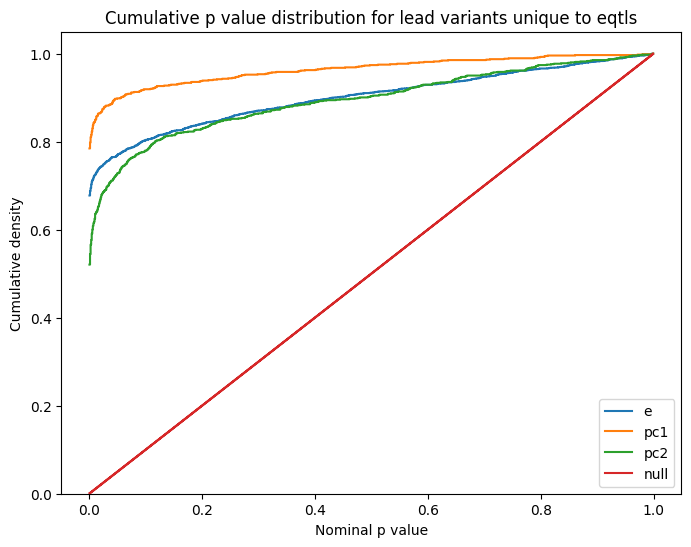

In [37]:
# lead variants exclusive to eqtls
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']>0)&(overlap_df['num_pc2_overlap']==0)&(overlap_df['num_pc1_overlap']==0)])
ax.set_title('Cumulative p value distribution for lead variants credible sets unique to eqtls')
plt.show()

# lead variants exclusive to pc2
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_samelead']>0)&(overlap_df['num_pc2_samelead']==0)&(overlap_df['num_pc1_samelead']==0)])
ax.set_title('Cumulative p value distribution for lead variants unique to eqtls')
plt.show()

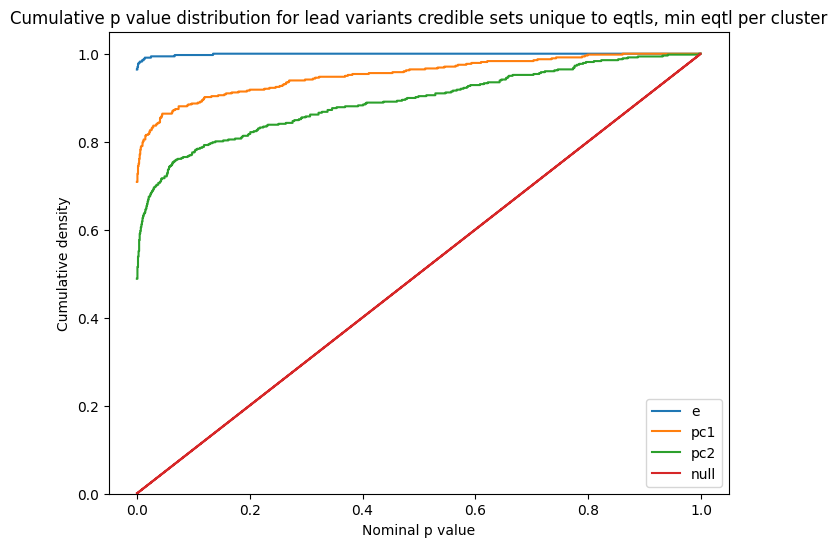

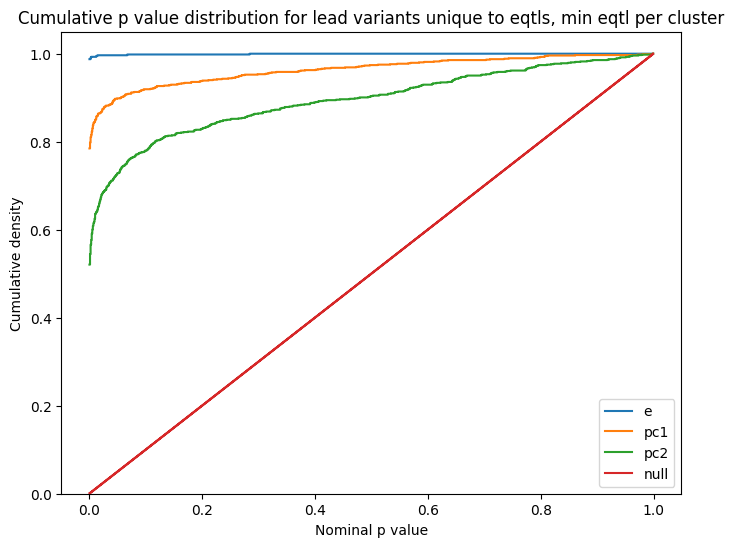

In [38]:
# lead variants exclusive to eqtls
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_overlap']>0)&(overlap_df['num_pc2_overlap']==0)&(overlap_df['num_pc1_overlap']==0)], min_e_per_cluster=True)
ax.set_title('Cumulative p value distribution for lead variants credible sets unique to eqtls, min eqtl per cluster')
plt.show()

# lead variants exclusive to pc2
ax = plot_nominal_ps(overlap_df[(overlap_df['num_e_samelead']>0)&(overlap_df['num_pc2_samelead']==0)&(overlap_df['num_pc1_samelead']==0)], min_e_per_cluster=True)
ax.set_title('Cumulative p value distribution for lead variants unique to eqtls, min eqtl per cluster')
plt.show()

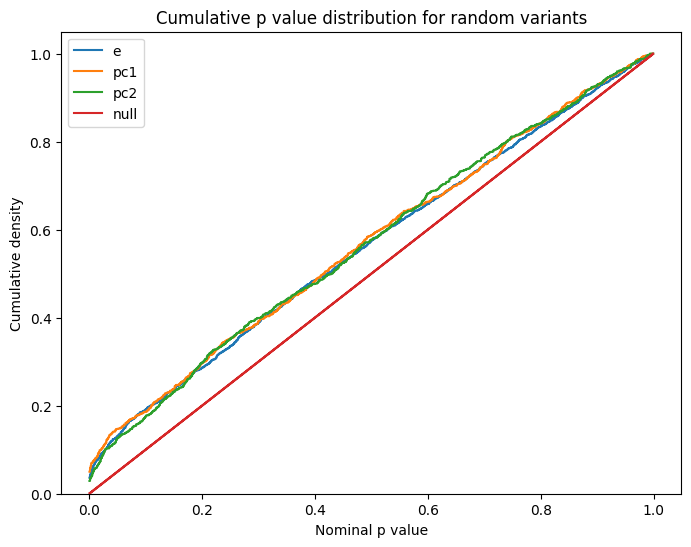

In [34]:
# against random selection of variants
random = pc1_nominal_df.sample(1000)

ax = plot_nominal_ps(random)
ax.set_title('Cumulative p value distribution for random variants')
plt.show()


## expression of pcqtl genes

maybe pcqtl genes are mroe lowly expressed, and so the power boost from considering multiple genes together is needed